# **DCGAN Adaptation**

Requires:
- Original model.
- Negative samples (obtained from feedback).

## **Imports**

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from scipy.linalg import sqrtm
from sklearn.manifold import TSNE

from copy import deepcopy
import time
import os

import networks as nws
import utils

## **Data**

In [2]:
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
# image_size = 28 # Mnist

# Batch size during training
batch_size = 64

# Number of workers for dataloader
workers = 2

# Root directory for dataset
# dataroot = "MNIST_ul1_data/1"
dataroot = "MNIST_ul8_data/8"

# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(
    root=dataroot,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        transforms.Resize((28, 28)), 
        transforms.Grayscale()
    ])
)
fisherdataset =  dset.MNIST(
        root="MNIST_full",
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ]),
        download=True
    )

dataset_name = dataroot.split("/")[0]

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
temp_dataloader = torch.utils.data.DataLoader(fisherdataset, batch_size=10000, shuffle=True)

print(len(dataloader))
print(len(temp_dataloader))

8
6


## **Models**

In [3]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

nz = 128
version = 3
G_final = nws.Generator(version=version, nz=nz).to(device)
D_final = nws.Discriminator(version=version).to(device)

# Tải trọng số vào mô hình
original_train_epochs = 300
original_save_dir = "checkpoints_original"
G_final.load_state_dict(torch.load(f'{original_save_dir}/gen_MNIST_full_v{version}_nz={nz}_epochs={original_train_epochs}.pth'))
D_final.load_state_dict(torch.load(f'{original_save_dir}/dis_MNIST_full_v{version}_nz={nz}_epochs={original_train_epochs}.pth'))

cuda:0


C:\Users\Admin\AppData\Local\Temp\ipykernel_7464\2683289933.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G_final.load_state_dict(torch.load(f'{original_save_dir}/gen

<All keys matched successfully>

## **EWC calculator**

In [4]:
class DCGANLoss_EWC:
    """
    Class for performing Elastic Weight Consolidation
    Reference link:
        https://discuss.pytorch.org/t/implementation-of-elastic-weight-consolidation-fisher-information-matrix/9309/3 
    """

    def __init__(self, G, D, criterion, device):
        self._G = G
        self._D = D
        self._crit = criterion
        self._dev = device
    

    def set_fisher(self, imgs_real, nsample=1, mean_loss=False):
        z = torch.randn(nsample, nz, 1, 1, device=self._dev)

        ###### GENERATOR FISHER
        # Compute Generator loss
        outsD_gen = self._D(self._G(z)).view(-1)
        real_label = torch.full((nsample,), 1.0, dtype=torch.float).to(device)
        loss_G = self._crit(outsD_gen, real_label)

        # Compute Generator gradients + Fisher
        loss_G.backward()
        self._fisher_G = {nameG: (paramG.grad.detach()**2) for nameG, paramG in self._G.named_parameters()}
        self._params_G = {n_G: p_G for n_G, p_G in self._G.named_parameters()}

        self._G.zero_grad()
        self._D.zero_grad()

        ###### DISCRIMINATOR FISHER
        #
        #-- Compute Discrimiator loss (real batch)
        outsD_real = self._D(imgs_real.to(self._dev)).view(-1)
        real_label = torch.full((imgs_real.size(0),), 1.0, dtype=torch.float).to(device)
        loss_D_real = self._crit(outsD_real, real_label)
        #
        #-- Compute Discriminator loss (generated batch)
        z_2 = torch.randn(nsample, nz, 1, 1, device=self._dev)
        outsD_gen_2 = self._D(self._G(z_2)).view(-1)
        fake_label = torch.full((nsample,), 0.0, dtype=torch.float).to(device)
        loss_D_gen = self._crit(outsD_gen_2, fake_label)
        #
        #-- Combines real + generated D loss
        loss_D = loss_D_real + loss_D_gen

        # Compute Discriminator gradients + Fisher
        loss_D.backward()
        self._fisher_D = {nameD: (paramD.grad.detach()**2) for nameD, paramD in self._D.named_parameters()}
        self._params_D = {n_D: p_D for n_D, p_D in self._D.named_parameters()}
        
        torch.cuda.empty_cache()


    def compute_EWC_G(self, G, weight=5e8):
        params = {n: p for n, p in G.named_parameters()}
        ewc, total = 0, 0
        for name in self._fisher_G:
            _ewc = self._fisher_G[name]*(params[name] - self._params_G[name])**2
            ewc += _ewc.sum()
            total += _ewc.numel()
        return weight * (ewc / total)
        # return weight * (ewc)
    

    def compute_EWC_D(self, D, weight=5e8):
        params = {n: p for n, p in D.named_parameters()}
        ewc, total = 0, 0
        for name in self._fisher_D:
            _ewc = self._fisher_D[name]*(params[name] - self._params_D[name])**2
            ewc += _ewc.sum()
            total += _ewc.numel()
        return weight * (ewc / total)
        # return weight * (ewc)
    

def param_diff(model0, model1):
    params0 = {n: p for n, p in model0.named_parameters()}
    params1 = {n: p for n, p in model1.named_parameters()}

    param_diffs = []
    for name in params0:
        dparam = ((params0[name] - params1[name])**2).mean().detach().cpu()
        param_diffs.append(dparam**2)

    return param_diffs

## **Set up EWC**

In [5]:
criterion = nn.BCELoss()

# Create a batch (64) of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

In [6]:
ewc = DCGANLoss_EWC(G=G_final, D=D_final, criterion=criterion, device=device)

nsample = 10000
real_imgs, _ = next(iter(temp_dataloader))
ewc.set_fisher(real_imgs, nsample=nsample)

### **Visualize Fisher information**

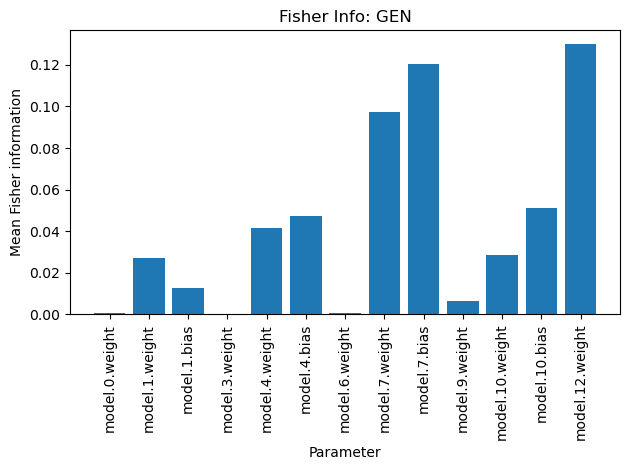

In [7]:
# Plot mean Fisher information
param_name_G, fisher_G = [], []
for name in ewc._fisher_G:
    param_name_G.append(name)
    fisher_G.append(ewc._fisher_G[name].mean().detach().cpu())

xticks = np.arange(len(fisher_G)) + 1
plt.bar(xticks, fisher_G)
plt.xticks(xticks, labels=param_name_G, rotation="vertical")
plt.xlabel("Parameter")
plt.xlim(0, len(fisher_G) + 1)
plt.ylabel("Mean Fisher information")
plt.title("Fisher Info: GEN")
plt.tight_layout()
plt.show()

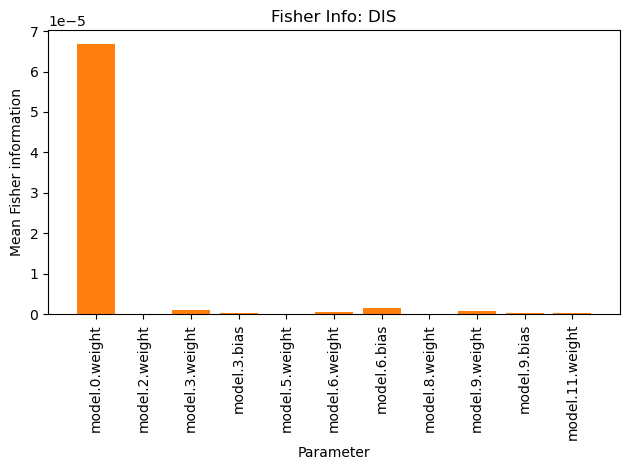

In [8]:
# Plot mean Fisher information
param_name_D, fisher_D = [], []
for name in ewc._fisher_D:
    param_name_D.append(name)
    fisher_D.append(ewc._fisher_D[name].mean().detach().cpu())

xticks = np.arange(len(fisher_D)) + 1
plt.bar(xticks, fisher_D, color="tab:orange")
plt.xticks(xticks, labels=param_name_D, rotation="vertical")
plt.xlabel("Parameter")
plt.xlim(0, len(fisher_D) + 1)
plt.ylabel("Mean Fisher information")
plt.title("Fisher Info: DIS")
plt.tight_layout()
plt.show()

## **Adaptation setup**

In [ ]:
gen_new = deepcopy(G_final)
dis_new = deepcopy(D_final)

optimizerG = optim.Adam(gen_new.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(dis_new.parameters(), lr=lr, betas=(beta1, 0.999))
del fisherdataset
del temp_dataloader
del G_final
del D_final

In [ ]:
num_epochs = 250
save_dir = "checkpoints_adapt"

print("-- Epochs: ", num_epochs)
print("-- Current z_dim: ", nz)
# print("-- Current optimizer & learning rate: ", c_optimizer, c_lr)
print("-- Is training netG: ", gen_new.training)
print("-- Is training netD: ", dis_new.training)
print("-- Device: ", device)

adapt_weight_D, adapt_weight_G = 0, 5e8
save_suffix_D = f"v{version}_nz={nz}_weight={adapt_weight_D}_epochs={num_epochs}_dataset={dataset_name}"
save_suffix_G = f"v{version}_nz={nz}_weight={adapt_weight_G}_epochs={num_epochs}_dataset={dataset_name}"
print(dataset_name)

save_dir = "checkpoints_adapt"
os.makedirs(save_dir, exist_ok=True)

plts_dir = f"plots/GAN_adapt"
os.makedirs(plts_dir, exist_ok=True)

-- Epochs:  250
-- Current z_dim:  128
-- Is training netG:  True
-- Is training netD:  True
-- Device:  cuda:0
MNIST_ul8_data


## **Adaptation function**

In [11]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
ewcG_losses = []
ewcD_losses = []
iters = 0
real_label = 1.0
fake_label = 0.0
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data, _) in enumerate(dataloader):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        dis_new.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        labels_real = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        outputD_real = dis_new(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(outputD_real, labels_real)
        D_x = outputD_real.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = gen_new(noise)
        labels_fake = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
        # Classify all fake batch with D
        outputD_fake = dis_new(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(outputD_fake, labels_fake)
        D_G_z1 = outputD_fake.mean().item()
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        # Compute error of D as sum over the fake and the real batches
        l_ewc_D = ewc.compute_EWC_D(dis_new, weight=adapt_weight_D)  # test with adapt weight = 0 or = config
        loss_D = errD_real + errD_fake + l_ewc_D
        loss_D.backward()
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        tG_start = time.time()
        gen_new.zero_grad()
        labels = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = gen_new(noise)
        outputD_fake_2 = dis_new(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(outputD_fake_2, labels)
        l_ewc_G = ewc.compute_EWC_G(gen_new, weight=adapt_weight_G)
        # Calculate gradients for G
        loss_G = errG + l_ewc_G
        loss_G.backward()
        D_G_z2 = outputD_fake_2.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f / %.4f\tLoss_G: %.4f / %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(dataloader),
                    loss_D.item(), l_ewc_D.item(), loss_G.item(), l_ewc_G.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
        ewcG_losses.append(l_ewc_G.item())
        ewcD_losses.append(l_ewc_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            print("gen")
            with torch.no_grad():
                fake = gen_new(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        torch.cuda.empty_cache()

    # # Lưu trọng số G tại epoch 10 và 50
    # if epoch == 10 or epoch == 50:
    #     torch.save(gen_new.state_dict(), f"{save_dir}/generator_adapt_epoch_{epoch}.pth")

torch.save(dis_new.state_dict(), f"{save_dir}/dis_adapted_{save_suffix_D}.pth")
torch.save(gen_new.state_dict(), f"{save_dir}/gen_adapted_{save_suffix_G}.pth")

Starting Training Loop...
[1/250][1/8]	Loss_D: 10.6641 / 0.0000	Loss_G: 3.5579 / 0.0000	D(x): 0.0001	D(G(z)): 0.0173 / 0.0885
gen
[2/250][1/8]	Loss_D: 0.2996 / 0.0000	Loss_G: 3.8962 / 0.0907	D(x): 0.9935	D(G(z)): 0.1569 / 0.0793
[3/250][1/8]	Loss_D: 0.2705 / 0.0000	Loss_G: 4.2971 / 0.1672	D(x): 0.8585	D(G(z)): 0.0647 / 0.0600
[4/250][1/8]	Loss_D: 0.1475 / 0.0000	Loss_G: 7.7120 / 0.2404	D(x): 0.8818	D(G(z)): 0.0006 / 0.0042
[5/250][1/8]	Loss_D: 0.0163 / 0.0000	Loss_G: 8.6535 / 0.3048	D(x): 0.9871	D(G(z)): 0.0029 / 0.0011
[6/250][1/8]	Loss_D: 0.0497 / 0.0000	Loss_G: 10.9893 / 0.3908	D(x): 0.9584	D(G(z)): 0.0020 / 0.0002
[7/250][1/8]	Loss_D: 0.0037 / 0.0000	Loss_G: 7.2629 / 0.4606	D(x): 0.9978	D(G(z)): 0.0014 / 0.0026
gen
[8/250][1/8]	Loss_D: 0.0011 / 0.0000	Loss_G: 7.4978 / 0.5209	D(x): 0.9992	D(G(z)): 0.0002 / 0.0079
[9/250][1/8]	Loss_D: 0.0120 / 0.0000	Loss_G: 7.6236 / 0.5858	D(x): 0.9994	D(G(z)): 0.0110 / 0.0085
[10/250][1/8]	Loss_D: 0.0093 / 0.0000	Loss_G: 5.5784 / 0.6339	D(x): 0.999

In [12]:
torch.cuda.empty_cache()

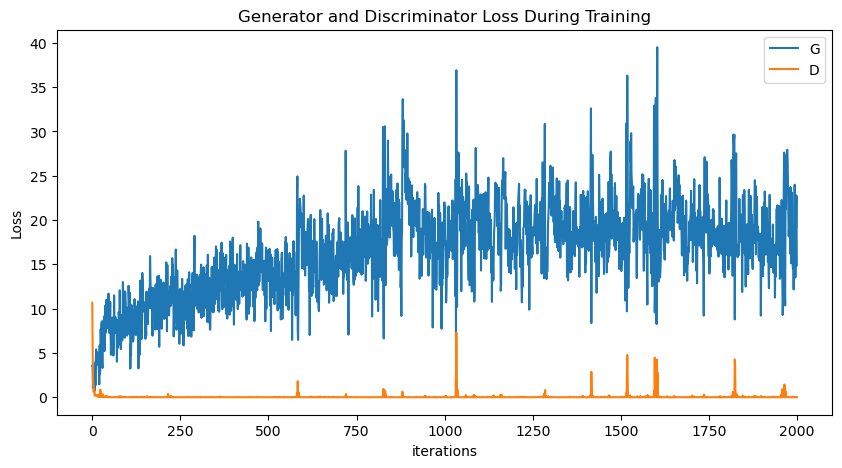

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

figname = f"{plts_dir}/GAN_loss_adapt_MNIST1_v{version}_weight={adapt_weight_G}_epochs={num_epochs}.jpg"
plt.savefig(figname, bbox_inches="tight")
plt.show()

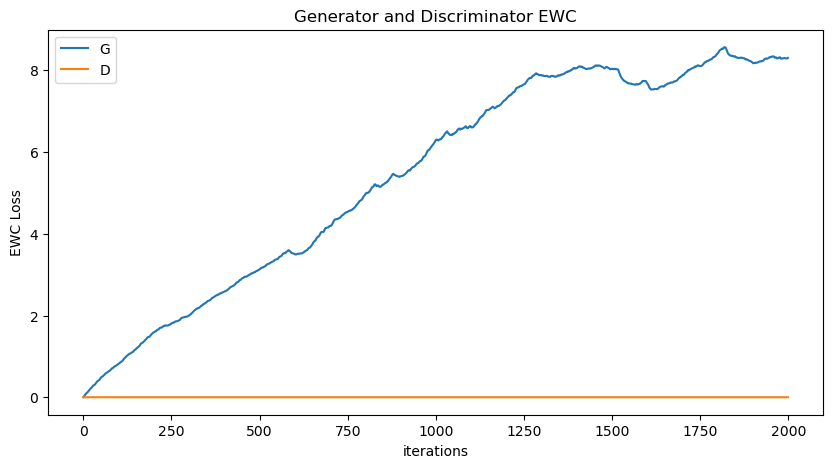

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator EWC")
plt.plot(ewcG_losses, label="G")
plt.plot(ewcD_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("EWC Loss")
plt.legend()

figname = f"{plts_dir}/GAN_EWC_v{version}_weight={adapt_weight_G}_epochs={num_epochs}.jpg"
plt.savefig(figname, bbox_inches="tight")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.axis("off")

ims = [np.transpose(i,(1,2,0)) for i in img_list]
img = ax.imshow(ims[0])

def update(i):
    if i < 15:
        img.set_array(ims[0])
        ax.set_title(f"Adapting features of digit '1', initial")
    elif i - 15 >= len(img_list) - 1:
        img.set_array(ims[-1])
        ax.set_title(f"Adapting features of digit '1', final")
    else:
        img.set_array(ims[i - 15])
        ax.set_title(f"Adapting features of digit '1', iteration: {(i - 15) * 70}")
    return [img]

ani = animation.FuncAnimation(
    fig, update, frames=len(img_list) + 30, interval=50, repeat_delay=1300, blit=True
)

# ani = animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=1000, blit=True)
ani.save(f"{plts_dir}/adaptProcess_{save_suffix_G}.gif")
HTML(ani.to_jshtml())

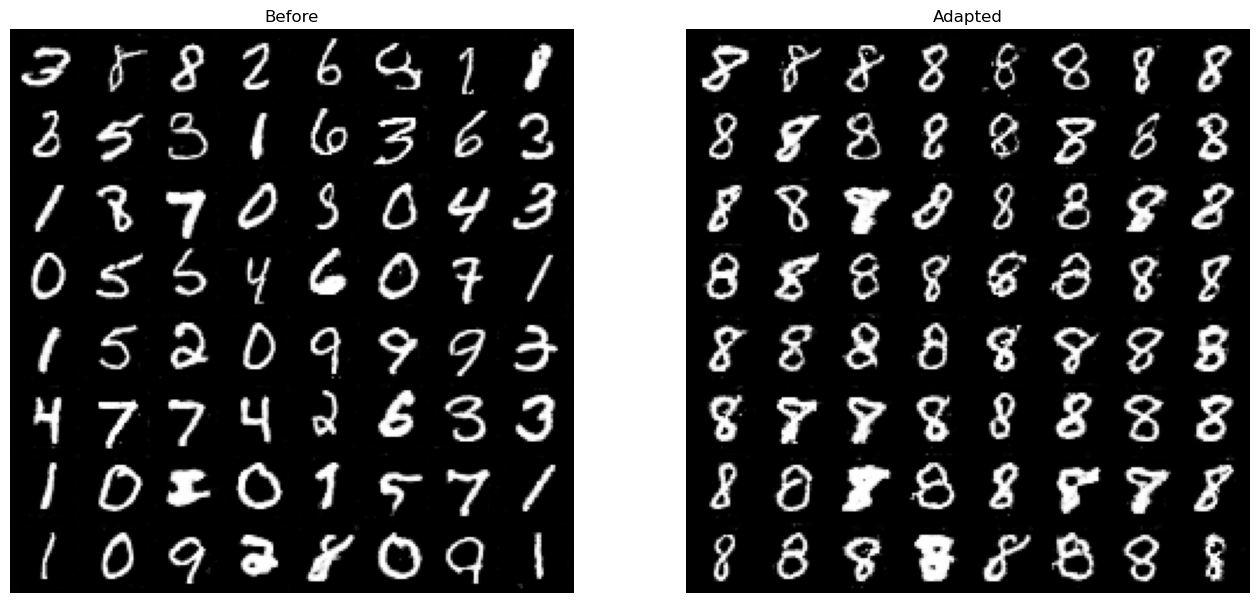

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].imshow(ims[0])
ax[0].set_title("Before")
ax[0].axis("off")
ax[1].imshow(ims[-1])
ax[1].set_title("Adapted")
ax[1].axis("off")
figname = f"{plts_dir}/GAN_adaptCompare_v{version}_weight={adapt_weight_G}_epochs={num_epochs}.jpg"
plt.savefig(figname, bbox_inches="tight")